In [58]:
pip install transformers


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
import PIL
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import models, transforms
from tqdm import tqdm

In [3]:
user_path = '/Users/umesh/Desktop/Saras_AI/brain_tumor/Training'

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), ## for considering 3 channels
    transforms.Resize((224, 224)), ## 224 because vision transformer we going to use accept images of this shape
    transforms.ToTensor()
])

pituitary


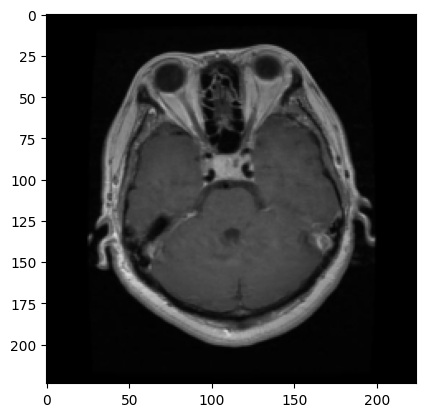

torch.Size([3, 224, 224])
notumor


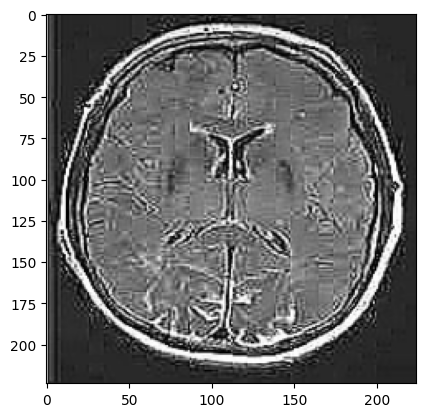

torch.Size([3, 224, 224])
glioma


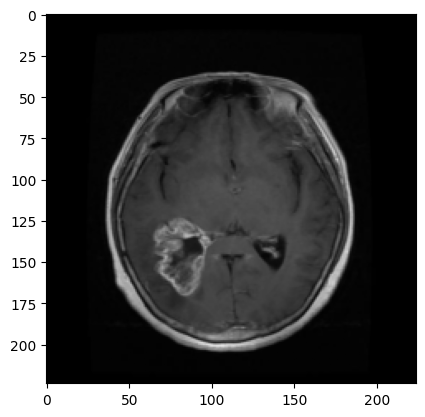

torch.Size([3, 224, 224])
meningioma


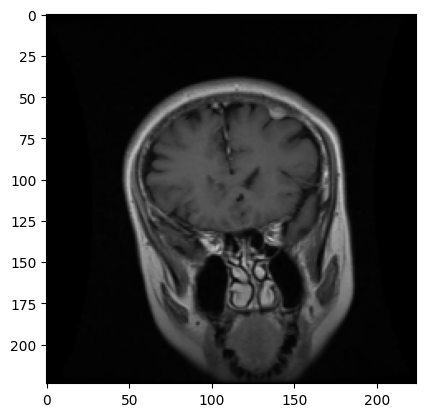

torch.Size([3, 224, 224])


In [5]:
## lets look at the images in the dataset
for folders in os.listdir(user_path):
    if folders =='.DS_Store':
        continue
    print(folders)
    folder_path = os.path.join(user_path, folders)
    for images in os.listdir(folder_path):
        img_path = os.path.join(folder_path, images)
        image = Image.open(img_path)
        image = transform(image)
        plt.imshow(image.permute(1, 2, 0))
        plt.show()
        print(image.shape)
        break

In [59]:
## lets collect all the images and keep the labels as 
## 0 for notumor
## 1 for glioma
## 2 for meningioma
## 3 for pituitary

In [23]:
def get_images_and_labels(user_path):
    images_list = []
    labels_list = []
    for folders in os.listdir(user_path):
        if folders =='.DS_Store':
            continue

        if folders == 'glioma':
            label = 1
        elif folders == 'meningioma':
            label = 2
        elif folders == 'notumor':
            label = 0
        elif folders == 'pituitary':
            label = 3

        folder_path = os.path.join(user_path, folders)

        for images in os.listdir(folder_path):
            img_path = os.path.join(folder_path, images)
            image = Image.open(img_path)
            image = transform(image)
            ## appending image to list
            images_list.append(image)
            ## appending the corresponding image to list
            labels = torch.tensor(label)
            labels_list.append(labels)

    return images_list, labels_list


In [24]:
all_images, all_labels = get_images_and_labels(user_path)

In [25]:
## lets check what do we get in all_images and all_labels
print(f'Total images we got are : {len(all_images)}')
print(f'Shape of Images are : {all_images[0].shape}')
print(f'Total labels we got are : {len(all_labels)}')

Total images we got are : 5712
Shape of Images are : torch.Size([3, 224, 224])
Total labels we got are : 5712


In [26]:
## now we'll make a custom dataloader
from torch.utils.data import DataLoader, Dataset

class CustomImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        label2 = torch.zeros(4)
        label2[label] = 1
        return image, label2

In [27]:
## dataset
dataset = CustomImageDataset(all_images, all_labels)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [28]:
## let see the few instance of this dataloader

images = next(iter(train_dataloader))
## images would be a list
print(f'First element shape is : {images[0].shape}')
print(f'Second element shape is : {images[1].shape}')

First element shape is : torch.Size([32, 3, 224, 224])
Second element shape is : torch.Size([32, 4])


In [13]:
## Fine now we can start working on loading our pre-trained Vision Transformer

In [29]:
# Load the pre-trained ViT model
model = models.vit_b_16(pretrained=True)

# Modify the final classification layer to match the number of classes
model.heads.head = nn.Linear(model.heads.head.in_features, 4)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
## loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [31]:
loss_store = []

In [71]:
## training time
epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for images, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_store.append(running_loss/len(train_dataloader))
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader)}")

print("Fine-tuning complete!")

100%|██████████| 179/179 [44:23<00:00, 14.88s/it]


Epoch [1/5], Loss: 0.3044376421678166


 60%|█████▉    | 107/179 [26:40<19:34, 16.31s/it]

In [ ]:
## saving the finetuned model
torch.save(model.state_dict(), "fine_tuned_vit.pth")

In [32]:
## Making evaluation dataset

test_set_path = '/Users/umesh/Desktop/Saras_AI/brain_tumor/Testing'

In [33]:
test_images, test_labels = get_images_and_labels(test_set_path)

print(f"Images in test dataset : {len(test_images)}")

test_dataset = CustomImageDataset(test_images, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

Images in test dataset : 1311


In [34]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [35]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            _, label = torch.max(labels, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return accuracy, precision, recall, f1

In [37]:
model.load_state_dict(torch.load("fine_tuned_vit.pth"))

<All keys matched successfully>

In [38]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [39]:
accuracy, precision, recall, f1 = evaluate_model(model, test_dataloader)
print(f'Model accuracy is : {accuracy}')

Model accuracy is : 0.9382151029748284


## Making a Gradio UI

In [40]:
pip install gradio


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
import gradio as gr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
def predict_image(img):
    
    image = transform(img)
    print(image.shape)
    image = image.unsqueeze(0)
    print(image.shape)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    class_names = ['notumor', 'glioma', 'meningioma', 'pituitary']  # Update with actual class names
    return class_names[predicted.item()]

In [43]:
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Text()
)

In [44]:
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
